介绍地理信息数据处理过程中使用的基本库以及使用demo 
- urllib
- minidom:适合处理<20M的文件，过大的话会有效率问题
- zipfile
- tarfile
- ElementTree: 更高级的xml解析器，有多语言版本，cElementTree效率更加高效
- BeautifulSoup: 绝大多数xml文档没有按照规范编写，并且包含许多的格式错误以及无效字符串，在地理空间分析中这种情况更为明显，所以需要一款解析器来获取问题格式文件中的数据,beautifulsoup 可以优雅的使用那些基于标签的数据，即使他们格式非常糟糕
- lxml: 功能更加强大的xml解析库
- shapely: 读写wkt、wkb文本;主要用途是通用几何库,python风格的几何操作库

    wkb(well-know binary):将wkt格式的字符串以二进制对象的形式存储在数据库中
- json/geojson : 处理geojson 数据；虽然可以通过eval(jsondata)直接将jsondata转换为python中的数据结构，但是这是不安全的，因为json支持一些python不支持的字符集，而不单单像看上去的那样是python字典和list对象的嵌套组合
- pyshp: 读写shapefile;只调用python标准库
- dbfpy3:专门处理dbf文件,安装: `pip install https://github.com/GeospatialPython/dbfpy3/archive/master.zip`
- fiona: 为OGR库的数据访问功能提供一套简洁的python api
- gdal: 栅格数据处理库
- PIL: 一般用于图像编辑，栅格绘制图片
- PNGCanvas: 轻量化的栅格化shapefile文件
- geopandas: 由shapely,fiona,pyproj,matplotlib,descaretes以及其他库一同构建的pandas的地理空间扩展
- PyFPDF: 轻量级的创建pdf文件

In [5]:
%config Completer.use_jedi = False

In [3]:
from osgeo import gdal
gdal.__version__

'3.6.2'

In [ ]:
import urllib.request
import urllib.parse
import urllib.error


url="https://github.com/GeospatialPython/Learn/raw/master/hancock.zip"
filename="hancock.zip"
urllib.request.urlretrieve(url,filename)


import zipfile
zip=open("hancock.zip", "rb")
zipShape=zipfile.ZipFile(zip)
shpname,shxName,dbName= zipShape.namelist()
for filename in zipShape.namelist():
    out= open(filename,"wb")
    out.write(zipShape.read(filename))
    out.close()

In [ ]:
import urllib.request
import urllib.parse
import urllib.error
import zipfile
import io
import struct

# 直接读取线上压缩包，无需下载到磁盘，内存中直接读取
url="https://github.com/GeospatialPython/Learn/raw/master/hancock.zip"
cloudshape=urllib.request.urlopen(url)
memoryshape= io.BytesIO(cloudshape.read())
zipshape= zipfile.ZipFile(memoryshape)
cloudshape= zipshape.read("hancock.shp")
struct.unpack("<dddd",cloudshape[36:68])



In [2]:
from xml.dom import minidom
kml= minidom.parse("time-stamp-point.kml")
placemarks=kml.getElementsByTagNamentsByTagName("Placemark")
len(placemarks)

first=placemarks[0]
first.toprettyxml()

coordinates= first.getElementsByTagName("coordinates")
point=coordinates[0].firstChild.data
point


'-122.536226,37.86047,0'

In [27]:
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET


tree=ET.ElementTree(file="time-stamp-point.kml")

ns="{http://www.opengis.net/kml/2.2}"
placemarks= tree.find(".//{}Placemark".format(ns))
print(placemarks)
coordinates= placemarks.find("./{}Point/{}coordinates".format(ns,ns))
print(coordinates)
coordinates.text

# 构建xml
root=ET.Element("kml")
root.attrib["xmlns"]="http://www.opengis.net/kml/2.2"
placemark= ET.SubElement(root,"Placemark")
office= ET.SubElement(placemark,"name")
office.text="Office"

point= ET.SubElement(placemark,"Point")
coordinates= ET.SubElement(point,"coordinates")
coordinates.text="-122.536226,37.86047,0"

tree=ET.ElementTree(root)
tree.write("placemark.kml",xml_declaration=True,encoding="utf-8",method="xml")


<Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x7f94b2bc1590>
<Element '{http://www.opengis.net/kml/2.2}coordinates' at 0x7f94b2bc1cc0>


In [33]:
from bs4 import  BeautifulSoup
import xml.etree.ElementTree as ET

#broken_data.gpx 文件最后缺失了一个</trkseg> 闭合标签
#ET.ElementTree(file="broken_data.gpx") # 报错

gpx=open("broken_data.gpx")
soup=BeautifulSoup(gpx.read(),features="xml")
soup.trkpt
tracks=soup.findAll("trkpt")
len(tracks)

# 重新输出正确的格式
fixed=open("fix_data.gpx","w")
fixed.write(soup.prettify())
fixed.close()



In [26]:
import shapely.wkt
import shapely.geometry

#shapely几何运算
wktpoly="POLYGON((103.30266237500007 35.293222467212644,105.45598268750007 35.293222467212644,104.70891237500007 31.62819408858728,100.88567018750007 33.29662370215108,103.30266237500007 35.293222467212644))"
poly= shapely.wkt.loads(wktpoly)
print("area:",poly.area)

poly.wkt
poly.wkb

buf=poly.buffer(5.0)
print("buf:",buf.area)

#多边形和缓冲区之间执行差异分析
dif=buf.difference(poly).area
print("diff:",dif)


# from osgeo  import ogr
# shape=ogr.Open("polygon.shp")
# layer= shape.GetLayer()
# feature= layer.GetNextFeature()
# geom= feature.GetGeometryRef()
# wkt=geom.ExportToWkt()
# poly=ogr.CreateGeometryFromWkt(wkt)
# poly.GetEnvelope()





area: 9.779021012527032
buf: 154.1934644134582
diff: 144.4144434009312


In [17]:
# geojson模块实现了python的__geo_interface__规范：该接口允许协作程序之间无缝传递数据，并且以python风格进行无需developer显式导入导出geojson.
# 所以如果想将geojson模块创建的点提供给shapely模块使用，只需直接读取geojson module 创建的点对象到shapely对象即可，之后就能够获取其wkt格式的数据。
import geojson
p=geojson.Point([-92,37])
geojs=geojson.dumps(p)
geojs



import shapely.geometry 
point= shapely.geometry.shape(p)
point.wkt

'POINT (-92 37)'

In [19]:
import shapefile
shp=shapefile.Reader("point/point.shp")
for feature in shp.shapeRecords():
    point=feature.shape.points[0]
    rec=feature.record[0]
    print(point[0],point[0],rec)

1.0 1.0 First
3.0 3.0 Second
4.0 4.0 Third
2.0 2.0 Fourth
0.0 0.0 Appended


In [20]:
import dbfpy3.dbf
db= dbfpy3.dbf.Dbf("GIS_CensusTract/GIS_CensusTract_poly.dbf")
rec=db[0]
print(rec)
filed=rec["POPULAT10"]
rec["POPULAT10"]=filed+1
rec.store()
del rec
db[0]["POPULAT10"]


 GEODB_OID: 4029 (<class 'int'>)
  OBJECTID: 4029 (<class 'int'>)
  PERMANE0: 61be9239-8f3b-4876-8c4c-0908078bc597 (<class 'str'>)
  SOURCE_1: NA (<class 'str'>)
  SOURCE_2: 20006 (<class 'str'>)
  SOURCE_3: Census Tracts (<class 'str'>)
  SOURCE_4: Census Bureau (<class 'str'>)
  DATA_SE5: 5 (<class 'str'>)
  DISTRIB6: E4 (<class 'str'>)
  LOADDATE: 2007-03-13 (<class 'datetime.date'>)
   QUALITY: 2 (<class 'str'>)
     SCALE: 1 (<class 'str'>)
     FCODE: 1734 (<class 'str'>)
  STCO_FI7: 22071 (<class 'str'>)
STATE_NAME: 22 (<class 'str'>)
  COUNTY_8: 71 (<class 'str'>)
  CENSUST9: 22071001734 (<class 'str'>)
 POPULAT10: 1760 (<class 'int'>)
  AREASQKM: 264.52661934 (<class 'float'>)
   GNIS_ID: NA (<class 'str'>)
 POPULAT11: 1665 (<class 'int'>)
 DB2GSE_12: 264526619.341326 (<class 'float'>)
 DB2GSE_13: 87406.4061920351 (<class 'float'>)


1761

In [52]:
import fiona
import pprint
f=fiona.open("GIS_CensusTract/GIS_CensusTract_poly.shp")
f.driver
f.crs
f.bounds

pprint.pprint(f.schema)

len(list(f))

(-89.8744162216216, 30.161122135135138, -89.1383837783784, 30.661213864864862)

In [57]:
from osgeo import gdal
raster=gdal.Open("SatImage/SatImage.tif")
raster.RasterCount #波段数量
raster.RasterXSize #水平方向的像素
raster.RasterYSize #垂直方向的像素

from osgeo import gdal_array
srcArray=gdal_array.LoadFile("SatImage/SatImage.tif")
band1= srcArray[0]
band1.shape

gdal_array.SaveArray(band1,"SatImage/band1.jpg",format="JPEG") #获取第一个波段并另存为jpg图片
gdal_array.SaveArray(srcArray[1],"SatImage/band2.jpg",format="JPEG")
gdal_array.SaveArray(srcArray[2],"SatImage/band3.jpg",format="JPEG")

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f929b8b0bd0> >

In [60]:
try:
    import Image
    import ImageDraw
    
except:
    from PIL import Image
    from PIL import ImageDraw

import shapefile
r=shapefile.Reader("hancock.shp")
xdist=r.bbox[2]-r.bbox[0]
ydist=r.bbox[3]-r.bbox[1]
iwidth=400
iheight=600
xratio=iwidth/xdist
yratio=iheight/ydist
pixels=[]
for x,y in r.shapes()[0].points:
    px=int(iwidth-((r.bbox[2]-x)*xratio))
    py=int((r.bbox[3]-y)*yratio)
    pixels.append((px,py))

img=Image.new("RGB",(iwidth,iheight),"White")
draw=ImageDraw.Draw(img)

draw.polygon(pixels,fill="rgb(203,196,190)",outline="rgb(198,204,189)")
img.save("hancock.png")

In [62]:
import shapefile
import pngcanvas

r=shapefile.Reader("hancock.shp")
xdist=r.bbox[2]-r.bbox[0]
ydist=r.bbox[3]-r.bbox[1]
iwidth=400
iheight=600
xratio=iwidth/xdist
yratio=iheight/ydist
pixels=[]
for x,y in r.shapes()[0].points:
    px=int(iwidth-((r.bbox[2]-x)*xratio))
    py=int((r.bbox[3]-y)*yratio)
    pixels.append((px,py))

c=pngcanvas.PNGCanvas(iwidth,iheight)
c.polyline(pixels)
f=open("hancock_pngcvs.png","wb")
f.write(c.dump())
f.close()

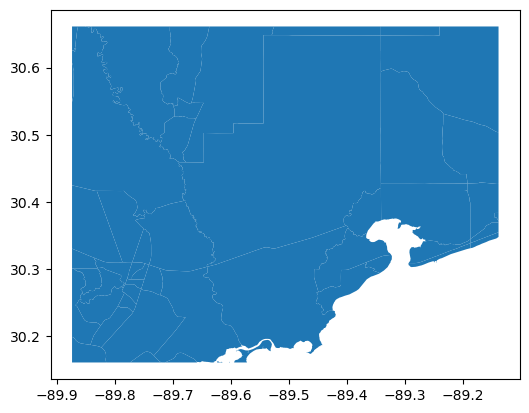

In [63]:
import geopandas
import matplotlib.pyplot as plt

#打开一个shapefile文件并将其转储为GeoJson格式,并使用matplotlib创建地图
gdf=geopandas.GeoDataFrame
census=gdf.from_file("GIS_CensusTract/GIS_CensusTract_poly.shp")
census.plot()
plt.show()


In [66]:
import fpdf

#导入png的图片转换为pdf文件

pdf=fpdf.FPDF("p","mm","A4")#pdf 图像构建器，毫米为单位，A4纸大小
pdf.add_page() #创建一个新的页面
pdf.set_font("Arial","B",20)
pdf.cell(160,25,"Hancock Country Boundary",border=0,align="C")#单元格布局样式：160*25，标题，无边框，居中
pdf.image("hancock.png",25,50,110,160)
pdf.output("map.pdf","F") # F=文件类型

''